# SkimLit

The purpose of this project is to build an NLP model to read medical abstracts easier.

The paper we are replicating is available here: https://arxiv.org/abs/1710.06071

Read this paper, we will see the model architecture they used to achieve the best results:  https://arxiv.org/abs/1612.05251


# Confirm access to GPU

In [1]:
!nvidia-smi

Thu Jul 27 10:03:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Getting the data ready

The datset is publicly available on: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 40.86 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


dev ==> validation set

# Data preprocessing

In [5]:
data_dir ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Function to read lines from text

In [7]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the line of text as list.

  Args:
  filename: a string containing the target filepath.

  Returns:
  A list of strings with one string per line from the target filename.
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
train_lines[:29]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

## Converting data to readable form

We want list of dicts.

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines': 11},
   .....]
  ```

In [10]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from. For example:

        [{"target": 'CONCLUSION',
          "text": The study couldn't have gone better, turns out people are kinder than you think",
          "line_number": 8,
          "total_lines": 8}]
    """


    input_lines = get_lines(filename)
    abstract_lines = ''
    abstract_samples = []
    for item in input_lines:
      if item.startswith('###'):
        abstract_lines = ''
      elif item.isspace():
        abstract_split_lines = abstract_lines.splitlines()

        for i, abstract_line in enumerate(abstract_split_lines):

          line_data = {}
          target_text_split = abstract_line.split("\t")

          line_data['line_number'] = i
          line_data['target'] = target_text_split[0]
          line_data['text'] = target_text_split[1]
          line_data['total_lines'] = len(abstract_split_lines)-1
          abstract_samples.append(line_data)
      else:
        abstract_lines += item
    return abstract_samples

In [11]:
preprocess_text_with_line_numbers("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [12]:
%time

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


(180040, 30212, 30135)

In [13]:
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [14]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
5,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,6,RESULTS,There was a clinically relevant reduction in t...,11
7,7,RESULTS,The mean difference between treatment arms ( @...,11
8,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,9,RESULTS,These differences remained significant at @ we...,11


In [16]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

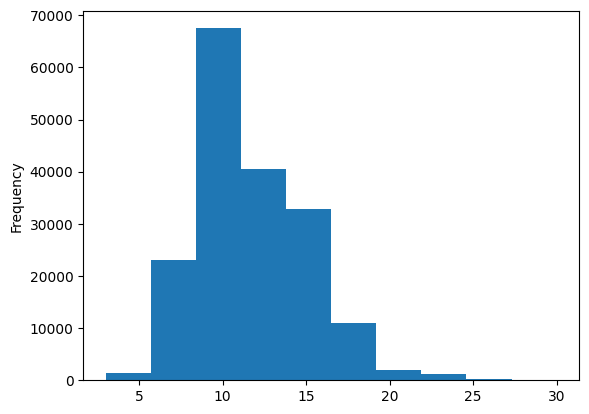

In [17]:
train_df.total_lines.plot(kind='hist');

In [18]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [19]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Train labels onehot encoded

In [20]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # TensorFlow is incompatible with sparse matrix datatype, so we need to set sparse_output to False

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Train labels encoded

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0 (Tfidf: Multinomial Bayes Model)

tfidf: covert text into numbers

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [25]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:5]

array([4, 1, 3, 2, 2])

In [26]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

## Import useful helper functions

In [27]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-27 10:03:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-27 10:03:51 (79.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [28]:
from helper_functions import calculate_results

In [29]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Tokenize and embed the train sentences

In [30]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

In [31]:
import numpy as np

In [32]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

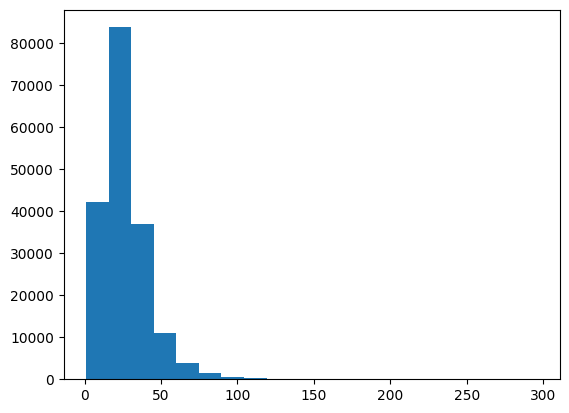

In [33]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20);

In [34]:
# How long sentences length cover 95% of the samples

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
max(sent_lens), min(sent_lens)

(296, 1)

In [36]:
# output_seq_len=55

In [37]:
max_tokens = 68000 # Check the research paper

## Text Vectorization (tokenization)

In [38]:
# How many words are there in our vocabulary

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len) # Tokenizing it

In [39]:
text_vectorizer.adapt(train_sentences)

In [40]:
import random

target_sentence = random.choice(train_sentences)
text_vectorizer([target_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 291,    9,   22, 1121,    6,  733,    7,  117, 2281,   25,  563,
        1124, 5187,    3, 3040,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [41]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [42]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Embedding

In [43]:
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                  output_dim=128,
                                  mask_zero=True,
                                  name='token_embedding')

In [44]:
print(f"Sentence:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Vectorized Sentence:\n {vectorized_sentence}\n")
embeded_sentence = token_embed(vectorized_sentence)
print(f"Embedded Sentence (untrained): \n {embeded_sentence}\n")
print(f"Shape of embeded layer:\n {embeded_sentence.shape}")

Sentence:
 Analyses were by intention to treat , with results expressed as odds ratios ( ORs ) and @ % CIs .

Vectorized Sentence:
 [[ 291    9   22 1121    6  733    7  117 2281   25  563 1124 5187    3
  3040    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded Sentence (untrained): 
 [[[-0.01627345 -0.01716592 -0.02572713 ... -0.00251471 -0.03117565
    0.02804773]
  [ 0.04055054  0.00979217 -0.04805582 ...  0.00449711 -0.03478144
    0.02784843]
  [-0.02149223 -0.03421853 -0.00664798 ...  0.02011839 -0.04820683
    0.02649559]
  ...
  [ 0.03616823 -0.02242038 -0.01964675 ...  0.00414478 -0.0464555
    0.03442408]
  [ 0.03616823 -0.02242038 -0.01964675 ...  0.00414478 -0.0464555
    0.03442408]
  [ 0.03616823 -0.02242038 -0.01964675 ...  0.00414478 -0.0464555
    0.03442408]]]

Shape of embeded layer:
 (1, 55, 128)


## Performant pipline of tensorflow

In [45]:
# Functionize the high performant pipeline
import tensorflow as tf

def create_dataset(inputs, labels):
  data = tf.data.Dataset.from_tensor_slices(inputs)
  data_label = tf.data.Dataset.from_tensor_slices(labels)
  dataset = tf.data.Dataset.zip((data, data_label))
  dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset

In [46]:
train_dataset = create_dataset(train_sentences, train_labels_one_hot)
val_dataset = create_dataset(val_sentences, val_labels_one_hot)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

# Model 1 (Conv1D)

In [47]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorized_layer = text_vectorizer(inputs)
embedded_layer = token_embed(vectorized_layer)
x = layers.Conv1D(64, 5, activation='relu', padding='same')(embedded_layer)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [48]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [49]:
len(train_dataset)*32 #Large amount of data, so we will reduce steps_per_epoch

180064

In [50]:
history_1 = model_1.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)), # It means it will only look at 10% of the training data,
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 44s 60ms/step - loss: 0.9193 - accuracy: 0.6371 - val_loss: 0.6864 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6557 - accuracy: 0.7584 - val_loss: 0.6324 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6138 - accuracy: 0.7760 - val_loss: 0.5930 - val_accuracy: 0.7859


In [51]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5938 - accuracy: 0.7872


[0.5938246250152588, 0.7872368693351746]

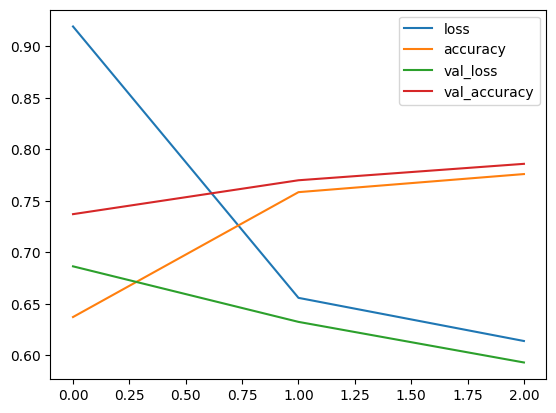

In [52]:
import pandas as pd
pd.DataFrame(history_1.history).plot();

In [53]:
model_1_pred_probs = model_1.predict(val_dataset)

945/945 [==============================] - 4s 5ms/step


In [54]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [55]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.72368595260161,
 'precision': 0.7846528764483123,
 'recall': 0.7872368595260162,
 'f1': 0.7851658895513142}

In [56]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 2 (Feature Extraction)

It is has pretrained token embeddings. Lets use pretrained word embedding from tensorflow hub: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used Glove embeddings, but we will use Universal Sentence Encoder

In [57]:
import tensorflow_hub as hub

embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                 trainable=False,
                 name='universal_sentence_encoder')

In [58]:
random_training_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_training_sentence}\n")
embedded_sentence = embed([random_training_sentence])
print(f"Embedded Sentence:\n {embedded_sentence[0][:30]}\n")
print(f"Shape of embedded sentence:\n {embedded_sentence.shape}")

Random Sentence:
 Double-blind , placebo-controlled trial in HIV + with CD@ ( + ) T cells/L ( CD@ ) @ randomized to receive the @-valent pneumococcal polysaccharide vaccine ( PPV@ ) or placebo at enrollment , followed by placebo or PPV@ , respectively , @-@ months later ( after @ months of ART ) .

Embedded Sentence:
 [-0.03495308 -0.06627743  0.05855786 -0.06685895 -0.05192417  0.05068052
  0.03531746 -0.04449512 -0.03751583 -0.05648633  0.07104494 -0.06315136
  0.05903665 -0.07212378  0.02314703  0.02130395 -0.07512617 -0.0506651
 -0.02695531 -0.04641798  0.07068941 -0.03296226 -0.07258172  0.0495703
 -0.00945841 -0.00166514 -0.0581747  -0.04000802 -0.03310572 -0.06080986]

Shape of embedded sentence:
 (1, 512)


In [59]:
inputs = layers.Input(shape=[], dtype=tf.string)
x = embed(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs,
                         name='feature_extractor_model')

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
model_2.summary()

Model: "feature_extractor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9170 - accuracy: 0.6510 - val_loss: 0.7964 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7683 - accuracy: 0.7012 - val_loss: 0.7542 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7517 - accuracy: 0.7107 - val_loss: 0.7383 - val_accuracy: 0.7118


In [62]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7402 - accuracy: 0.7146


[0.7402318716049194, 0.7145504951477051]

In [63]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[0.41523737, 0.37415865, 0.00264963, 0.19973809, 0.00821627],
       [0.3318814 , 0.51782995, 0.00436347, 0.14281811, 0.00310704],
       [0.24935983, 0.1406263 , 0.02270414, 0.5522396 , 0.0350701 ],
       ...,
       [0.00199735, 0.00681276, 0.05047146, 0.0010329 , 0.9396856 ],
       [0.00437955, 0.0476417 , 0.1738344 , 0.0013941 , 0.77275026],
       [0.18396753, 0.22974578, 0.5112069 , 0.0077247 , 0.06735513]],
      dtype=float32)

In [64]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [65]:
feature_extraction_result = calculate_results(val_labels_encoded, model_2_preds)
feature_extraction_result

{'accuracy': 71.45505097312326,
 'precision': 0.7148247451503094,
 'recall': 0.7145505097312326,
 'f1': 0.7116529126939304}

In [66]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'D o u b l e - b l i n d   ,   p l a c e b o - c o n t r o l l e d   t r i a l   i n   H I V   +   w i t h   C D @   (   +   )   T   c e l l s / L   (   C D @   )   @   r a n d o m i z e d   t o   r e c e i v e   t h e   @ - v a l e n t   p n e u m o c o c c a l   p o l y s a c c h a r i d e   v a c c i n e   (   P P V @   )   o r   p l a c e b o   a t   e n r o l l m e n t   ,   f o l l o w e d   b y   p l a c e b o   o r   P P V @   ,   r e s p e c t i v e l y   ,   @ - @   m o n t h s   l a t e r   (   a f t e r   @   m o n t h s   o f   A R T   )   .'

In [67]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [68]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

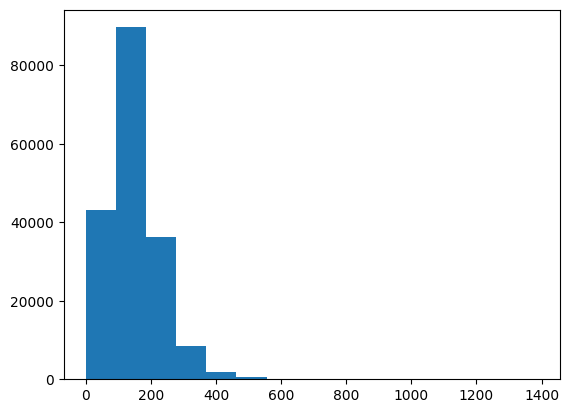

In [69]:
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=15);

In [70]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [71]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
max_tokens = len(alphabet) + 2 # (for space and OOV(unknown characters))

In [73]:
char_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation', # truncating the punctuations
                                    name='char_vectorizer')

char_vectorizer.adapt(train_chars)

In [74]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [75]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nShape of vectorized char: {vectorized_chars.shape}")

Charified text:
U P   g r a f t i n g   w i t h   i n n e r   p r e p u t i a l   s k i n   ,   w h e n   a d d e d   t o   t h e   T I P   p r o c e d u r e   i n   t h e   t r e a t m e n t   o f   P H   ,   r e s u l t s   i n   a   s i g n i f i c a n t l y   s m a l l e r   n u m b e r   o f   u n s a t i s f a c t o r y   r e s u l t s   ,   a n d   p a r t i c u l a r l y   f e w e r   c a s e s   o f   n e o u r e t h r a l   s t e n o s i s   .

Length of chars: 185

Vectorized chars:
[[16 14 18  8  5 17  3  4  6 18 20  4  3 13  4  6  6  2  8 14  8  2 14 16
   3  4  5 12  9 23  4  6 20 13  2  6  5 10 10  2 10  3  7  3 13  2  3  4
  14 14  8  7 11  2 10 16  8  2  4  6  3 13  2  3  8  2  5  3 15  2  6  3
   7 17 14 13  8  2  9 16 12  3  9  4  6  5  9  4 18  6  4 17  4 11  5  6
   3 12 19  9 15  5 12 12  2  8  6 16 15 22  2  8  7 17 16  6  9  5  3  4
   9 17  5 11  3  7  8 19  8  2  9 16 12  3  9  5  6 10 14  5  8  3  4 11
  16 12  5  8 12 19 17  2 20  2  8 11  5  9  2  9  7 17  

In [76]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # From the paper
                              mask_zero=True,
                              name='char_embed')

In [77]:
print(f"Random Character Sentence:\n {random_train_chars}\n")
vectorized_sentence = char_vectorizer([random_train_chars])
print(f"Vectorized Character Sentence:\n {vectorized_sentence}\n")
print(f"Shape: {vectorized_sentence.shape}\n")
embedded_char_sentence = char_embed(vectorized_sentence)
print(f"Embedded Character Sentence:\n {embedded_char_sentence}")
print(f"Shape: {embedded_char_sentence.shape}")

Random Character Sentence:
 U P   g r a f t i n g   w i t h   i n n e r   p r e p u t i a l   s k i n   ,   w h e n   a d d e d   t o   t h e   T I P   p r o c e d u r e   i n   t h e   t r e a t m e n t   o f   P H   ,   r e s u l t s   i n   a   s i g n i f i c a n t l y   s m a l l e r   n u m b e r   o f   u n s a t i s f a c t o r y   r e s u l t s   ,   a n d   p a r t i c u l a r l y   f e w e r   c a s e s   o f   n e o u r e t h r a l   s t e n o s i s   .

Vectorized Character Sentence:
 [[16 14 18  8  5 17  3  4  6 18 20  4  3 13  4  6  6  2  8 14  8  2 14 16
   3  4  5 12  9 23  4  6 20 13  2  6  5 10 10  2 10  3  7  3 13  2  3  4
  14 14  8  7 11  2 10 16  8  2  4  6  3 13  2  3  8  2  5  3 15  2  6  3
   7 17 14 13  8  2  9 16 12  3  9  4  6  5  9  4 18  6  4 17  4 11  5  6
   3 12 19  9 15  5 12 12  2  8  6 16 15 22  2  8  7 17 16  6  9  5  3  4
   9 17  5 11  3  7  8 19  8  2  9 16 12  3  9  5  6 10 14  5  8  3  4 11
  16 12  5  8 12 19 17  2 20  2  8 11  5  9  2  9  7 

# Model 3(Conv1D)

Char embedding only

In [78]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)

char_model = tf.keras.Model(inputs, outputs, name="char_embed_model")

char_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

In [79]:
char_model.summary()

Model: "char_embed_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)            

In [80]:
train_char_dataset = create_dataset(train_chars, train_labels_one_hot)
val_char_dataset = create_dataset(val_chars, val_labels_one_hot)
test_char_dataset = create_dataset(test_chars, test_labels_one_hot)

In [81]:
char_history = char_model.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2748 - accuracy: 0.4708 - val_loss: 1.0621 - val_accuracy: 0.5708
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0097 - accuracy: 0.5966 - val_loss: 0.9385 - val_accuracy: 0.6273
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9194 - accuracy: 0.6390 - val_loss: 0.8646 - val_accuracy: 0.6646


In [82]:
char_model.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8777 - accuracy: 0.6596


[0.8777100443840027, 0.6595723628997803]

In [83]:
char_model_pred_probs = char_model.predict(val_char_dataset)
char_model_pred = tf.argmax(char_model_pred_probs, axis=1)
char_model_pred

945/945 [==============================] - 2s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 1])>

In [84]:
char_model_results = calculate_results(val_labels_encoded, char_model_pred)
char_model_results

{'accuracy': 65.95723553554879,
 'precision': 0.649883983108112,
 'recall': 0.6595723553554879,
 'f1': 0.6481894785606189}

# Model 4 (`model 1` + `model 3`)

Token Embeddings + Character Embeddings


1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers similar to Figure 1 of section 4.2 in https://arxiv.org/pdf/1612.05251.pdf

In [85]:
# Token Embedding model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = embed(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Character Embedding model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Concatinate both models by taking their outputs
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat) # randomly sets 50% of weights to 0 to prevent overfitting
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout_layer = layers.Dropout(0.5)(combined_dense) # following instructions from the paper
output_layer = layers.Dense(5, activation='softmax')(final_dropout_layer)

model_4 = tf.keras.Model(inputs=[token_inputs, char_inputs], # Can use model.input as well
                         outputs=output_layer,
                         name='token_and_char_embeddings')

model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [86]:
model_4.summary()

Model: "token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

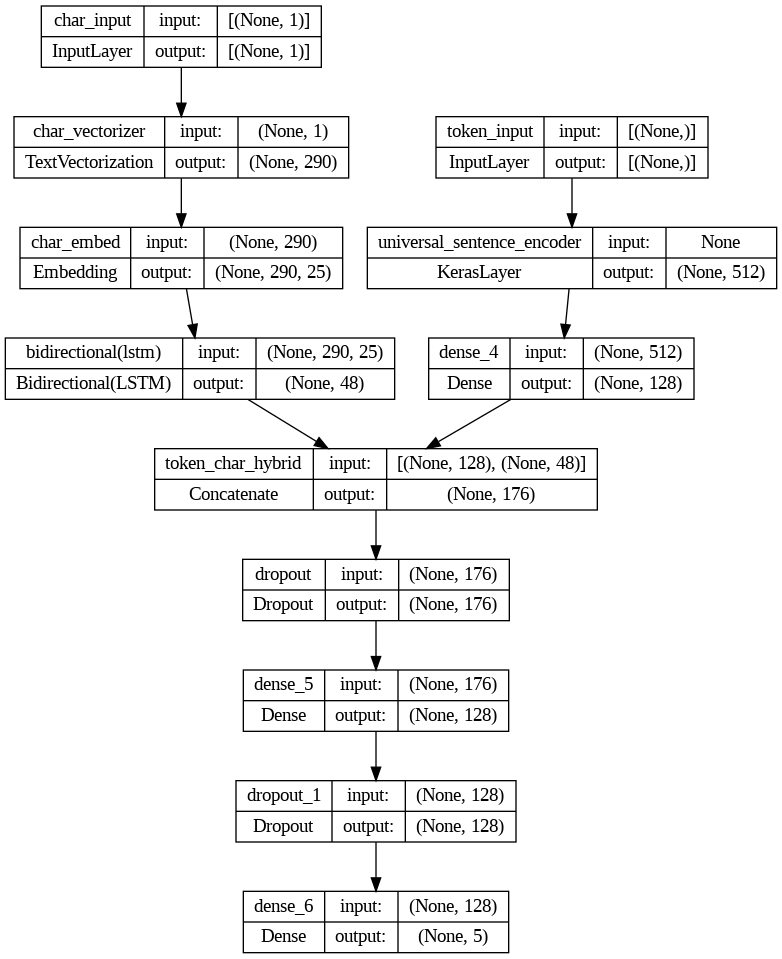

In [87]:
# Plotting the model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [88]:
train_char_token_dataset = create_dataset((train_sentences, train_chars), train_labels_one_hot)
val_char_token_dataset = create_dataset((val_sentences, val_chars), val_labels_one_hot)
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [89]:
history_4 = model_4.fit(train_char_token_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                        validation_data=val_char_token_dataset,
                        validation_split=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 59s 86ms/step - loss: 0.9834 - accuracy: 0.6108 - val_loss: 0.7874 - val_accuracy: 0.7012
Epoch 2/3
562/562 [==============================] - 67s 120ms/step - loss: 0.8003 - accuracy: 0.6931 - val_loss: 0.7219 - val_accuracy: 0.7249
Epoch 3/3
562/562 [==============================] - 43s 76ms/step - loss: 0.7713 - accuracy: 0.7022 - val_loss: 0.6981 - val_accuracy: 0.7301


In [90]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6981 - accuracy: 0.7301


[0.6981437802314758, 0.7300741672515869]

In [91]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

945/945 [==============================] - 21s 19ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [92]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.00741427247452,
 'precision': 0.7309391716285312,
 'recall': 0.7300741427247451,
 'f1': 0.7267533118259936}

# Model 5 (`model 4` + pos embed)

Token embed + character embed + positional embed

In [93]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


## Feature engineering

* Line number and total lines are important features that is helpful in classifying the sentence
* One important thing to keep in mind is if these features are available during the testing time (available ✅).

In [94]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

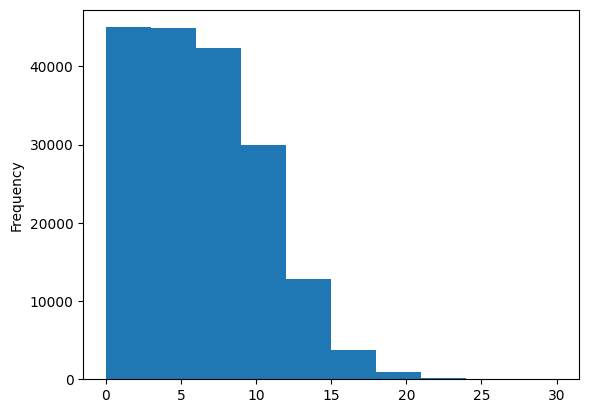

In [95]:
train_df['line_number'].plot(kind='hist');

In [96]:
np.percentile(train_df['line_number'], 98) # Covers almost everything

15.0

## Line numbers one hot

In [97]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'], depth=15) # tf.one_hot only takes in tensor indices.
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'], depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'], depth=15)

In [98]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

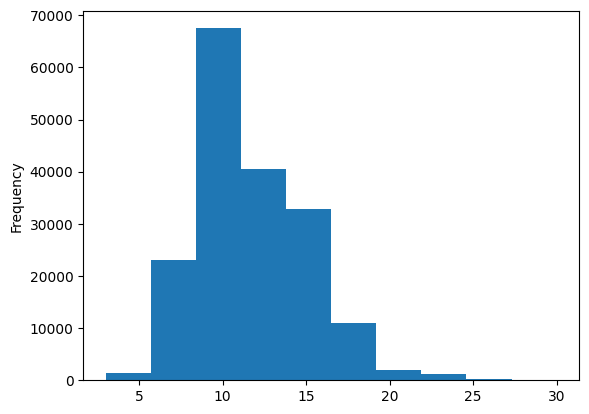

In [99]:
train_df['total_lines'].plot(kind='hist');

In [100]:
np.percentile(train_df['total_lines'], 98)

20.0

## Total lines one hot

In [101]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

## Build a tribid model

1. Create  a token level model
2. Create a character level model
3. Create a model for "line number" feature
4. Create a model for "total lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.Concatenate and pass it to a dropout layer
6. Combine the outputs of 3, 4 and 5 using tf.keras.Concatenate
7. Create an output layer to accept the tribid model (using layers.Dense())
8. Combine the inputs and outputs to finally create the model

In [102]:
# 1.
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
embedded_layer = embed(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(embedded_layer)
token_model = tf.keras.Model(token_inputs, token_outputs)

#2.
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vector = char_vectorizer(char_inputs)
char_embed_layer = char_embed(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed_layer)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3.
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

#4.
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

#5.
combined_embeddings = layers.Concatenate(name='char_token_hybrid')([token_model.output, char_model.output])
x = layers.Dense(256, activation='relu')(combined_embeddings)
x = layers.Dropout(0.5)(x)


#6.
tribid_embeddings = layers.Concatenate(name='tribid_embeddings')([line_number_model.output,
                                                                     total_lines_model.output,
                                                                     x])

#7.
output_layer = layers.Dense(5, activation='softmax')(tribid_embeddings)

#8.
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='tribid_model')

In [103]:
model_5.summary()

Model: "tribid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']

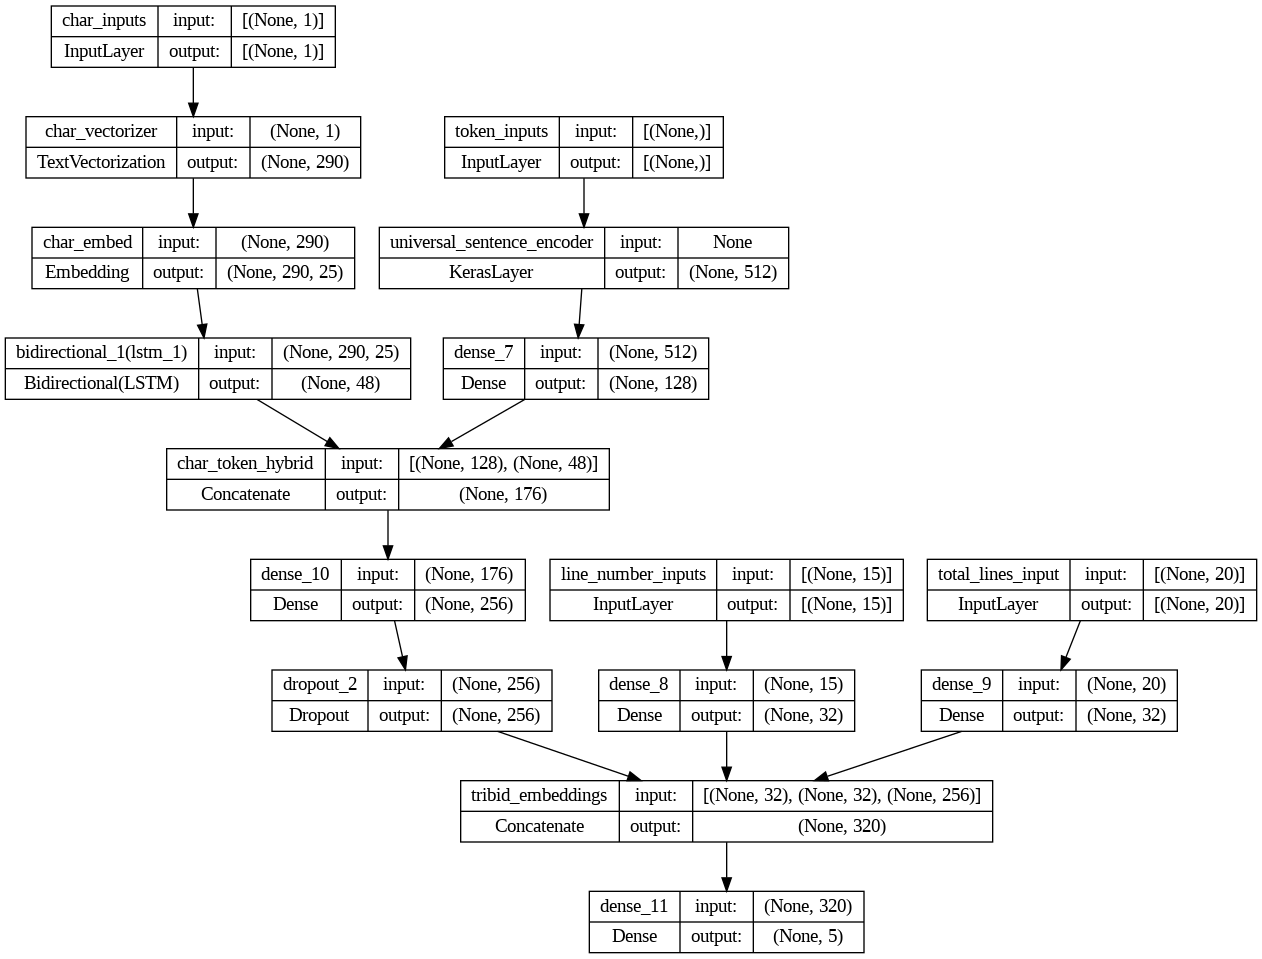

In [104]:
# Plotting the model
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [105]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label smoothing reduces over-confidence of model, we had to use onehot encoded labels because label smoothing is there only for categorical crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


## High performant pipline for the tribrid model

In [106]:
train_pos_char_token_dataset = create_dataset((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars),
                                              train_labels_one_hot)

val_pos_char_token_dataset = create_dataset((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars),
                                            val_labels_one_hot)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [107]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 55ms/step - loss: 1.0961 - accuracy: 0.7225 - val_loss: 0.9882 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9673 - accuracy: 0.8146 - val_loss: 0.9527 - val_accuracy: 0.8221
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9519 - accuracy: 0.8208 - val_loss: 0.9429 - val_accuracy: 0.8265


In [108]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 22s 20ms/step


array([[0.5118571 , 0.11998112, 0.0107892 , 0.34007686, 0.01729571],
       [0.56871766, 0.08892319, 0.0392522 , 0.2933492 , 0.00975774],
       [0.33742288, 0.1062148 , 0.11385274, 0.3704192 , 0.07209045],
       ...,
       [0.0304619 , 0.09185839, 0.03495348, 0.02841818, 0.81430805],
       [0.03033282, 0.30878577, 0.07896733, 0.02332927, 0.5585848 ],
       [0.20379828, 0.661642  , 0.05843458, 0.03210938, 0.04401572]],
      dtype=float32)

In [109]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [110]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.92069376406725,
 'precision': 0.8289679826977111,
 'recall': 0.8292069376406725,
 'f1': 0.828089914078524}

# Compare model predictions

In [111]:
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                  'custom_token_embed_conv1d': model_1_results,
                                  'pretrained_token_embed': feature_extraction_result,
                                  'custom_char_embed_conv1d': char_model_results,
                                  'hybrid_char_token_embed': model_4_results,
                                  'tribrid_pos_char_token_embed': model_5_results}
              )
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.723686,0.784653,0.787237,0.785166
pretrained_token_embed,71.455051,0.714825,0.714551,0.711653
custom_char_embed_conv1d,65.957236,0.649884,0.659572,0.648189
hybrid_char_token_embed,73.007414,0.730939,0.730074,0.726753
tribrid_pos_char_token_embed,82.920694,0.828968,0.829207,0.828090


In [112]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

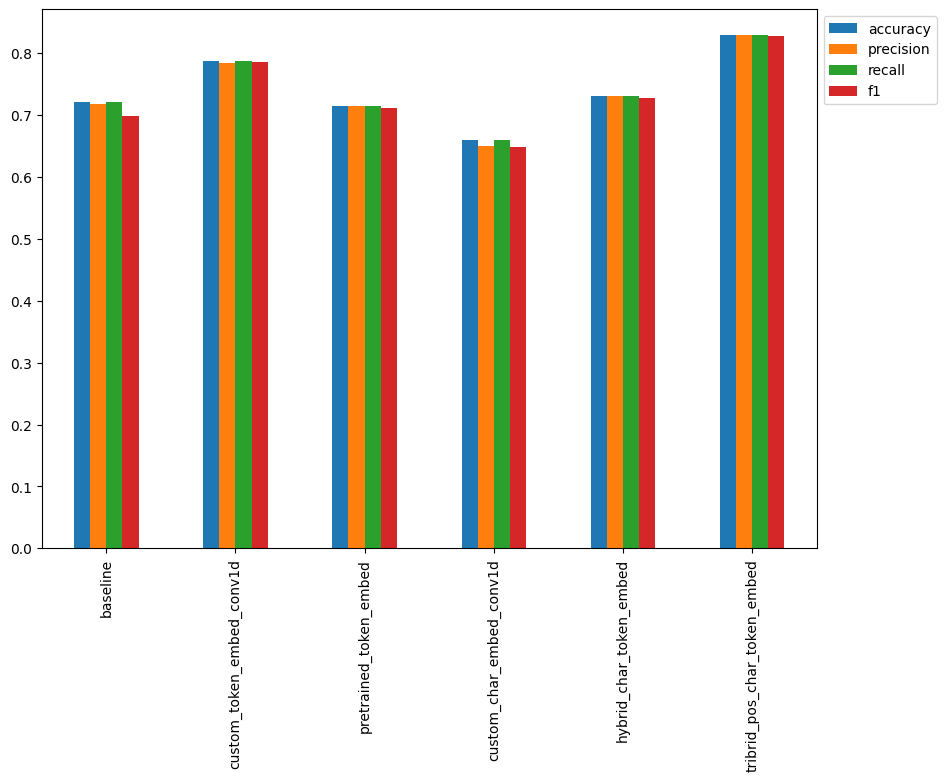

In [113]:
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=[1, 1]);

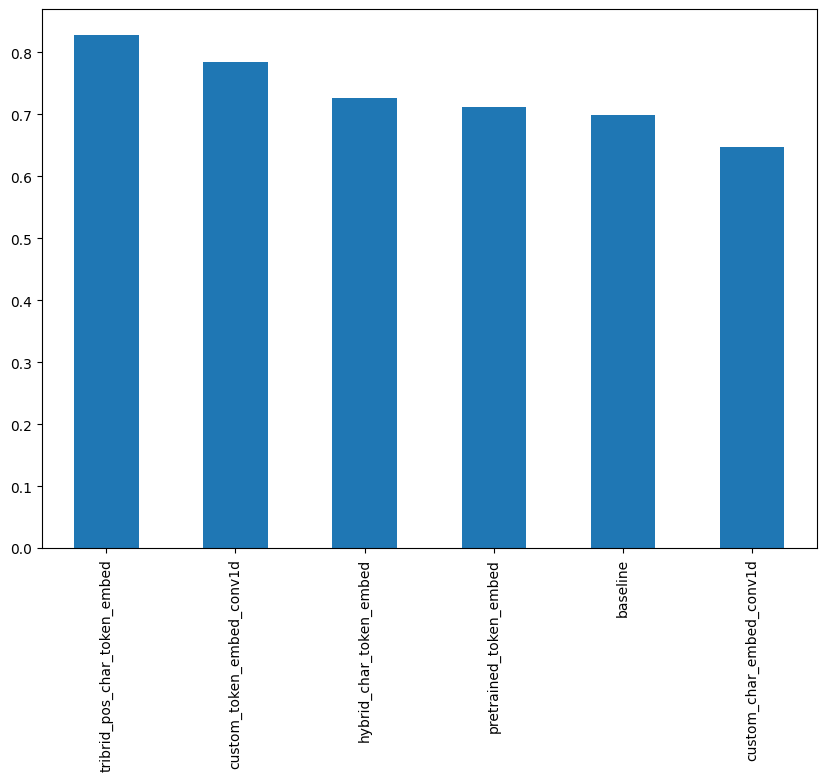

In [114]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));

# Evaluate on test dataset

In [115]:
test_chars[:5], test_sentences[:5], test_line_numbers_one_hot[:5], test_total_lines_one_hot[:5]

(['T h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   A D H F   )   .',
  'A   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   E v a l u a t i o n   S t u d y   o f   C o n g e s t i v e   H e a r t   F a i l u r e   a n d   P u l m o n a r y   A r t e r y   C a t h e t e r i z a t i o n   E f f e c t i v e n e s s   (   E S C A P E   )   .',
  'L i v e r   f u n c t i o n   t e s t s   (   L F T s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
  'S u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t 

In [116]:
test_pos_char_token_dataset = create_dataset((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars),
                                          test_labels_one_hot)

test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [117]:
model_5.evaluate(test_pos_char_token_dataset)

942/942 [==============================] - 20s 22ms/step - loss: 0.9486 - accuracy: 0.8244


[0.9486441016197205, 0.8244234323501587]

In [118]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset)

942/942 [==============================] - 18s 19ms/step


In [119]:
test_preds = tf.argmax(test_pred_probs, axis=1)
calculate_results(test_labels_encoded, test_preds)

{'accuracy': 82.44234279077484,
 'precision': 0.8236320460243682,
 'recall': 0.8244234279077485,
 'f1': 0.8233060481544966}